# Sentiment analysis: *Amazon fine food review*

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install -qq transformers
!pip install lightgbm

     |████████████████████████████████| 3.5 MB 3.2 MB/s 
     |████████████████████████████████| 67 kB 5.3 MB/s 
     |████████████████████████████████| 895 kB 45.9 MB/s 
     |████████████████████████████████| 6.8 MB 48.1 MB/s 
     |████████████████████████████████| 596 kB 48.5 MB/s 


## Introduction

### Group members

**Minimum 2, Maximum 3**

<span style="color:red">Write below</span>

* Last, First name
* Last, First name
* Last, First name

### Presentation

* The project is based on the Amazon food review from customers dataset
* The original Kaggle competition was to predict whether a review was positive or negative
* In this project, we will add the **neural** level
* You will try to **predict the 3 classes** given by the user according to their **review**
* For this, you will need to use at least 2 **sentence embeddings techniques** (e.g., Word2Vec, BERT)
* The primary metric we will focus on is the **macro-averaged f1-score**
* The dataset contains more than 500K reviews

### Project evaluation

* **4 points**: Exploratory analysis

* **4 points**: Clean and well-documented code (do not forget to **cite** code you reuse, or it will be considered plagiarism)

* **4 points**: Modeling and feature extractions

* **4 points**: Evaluation of the performance of the model

* **4 points**: Quality of the oral presentation

### Download the data

https://www.kaggle.com/snap/amazon-fine-food-reviews/download

(254MB)

In [3]:
import re
from pathlib import Path

import gensim
import gensim.downloader as gensim_api
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import wordcloud
from sklearn import (
    decomposition,
    ensemble,
    feature_extraction,
    linear_model,
    metrics,
    model_selection,
    naive_bayes,
    pipeline,
)
from sklearn.feature_extraction.text import CountVectorizer
from tqdm.notebook import tqdm
from wordcloud import WordCloud
from collections import Counter
import time
from lightgbm import LGBMClassifier

In [4]:
import transformers
from transformers import BertModel, BertTokenizerFast, AdamW, get_linear_schedule_with_warmup
import torch
from torch.utils.data import TensorDataset, DataLoader

In [5]:
sns.set_style("darkgrid")
sns.set_context("notebook")

tqdm.pandas()

%config InlineBackend.figure_format="retina"  # For high DPI display
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(device)

cuda:0


In [6]:
DATA = Path("/content/drive/MyDrive/saclay/hands_on_nlp/project/archive")

assert DATA.is_dir()

IMG = Path("/content/drive/MyDrive/saclay/hands_on_nlp/project/img")

assert IMG.is_dir()

## Exploration

### Read Data

In [7]:
df = pd.read_csv(DATA / "Reviews_small.csv.xz")
df.head()

,Unnamed: 0,Score,Summary,Text
0,0,5,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,1,1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,2,4,"""Delight"" says it all",This is a confection that has been around a fe...
3,3,2,Cough Medicine,If you are looking for the secret ingredient i...
4,4,5,Great taffy,Great taffy at a great price. There was a wid...


* Contains some product, user, and review information

* Data used here:

    * Text: Complete product review by the customer
    * Summary: Summary proposed by the customer
    * Score: The product rating provided by the customer

In [8]:
num_entries = df.shape[0]
nulls_summary = df["Summary"].isnull().sum()
nulls_text = df["Text"].isnull().sum()

print("There are %9d entries in our dataset.\nThere are %3d null values for the Summary column, and %2d null values for the Text column." % (num_entries, nulls_summary, nulls_text))

There are    394970 entries in our dataset.
There are   3 null values for the Summary column, and  0 null values for the Text column.


In [9]:
# Checking if there are duplicated rows (taking into account all the columns)
print("There are %d duplicated rows" % df.duplicated().sum())

#Now check duplicates of texts
print("There are %d duplicated texts." % df.duplicated(subset=["Summary","Text"]).sum())

There are 0 duplicated rows
There are 0 duplicated texts.


### Distribution of the variable ***Score***

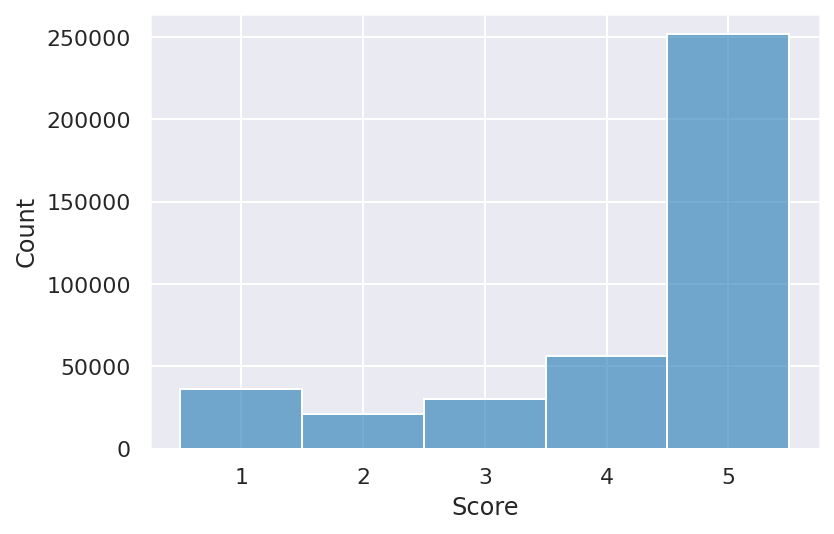

In [10]:
sns.histplot(df, x="Score", alpha=0.6, discrete=True)
plt.show()

* Most of the customer rating is positive 

### Analysis of binary and 3-classes versions

* Convert the 5-classes rating in 3-classes sentiment as a target variable
* Positive reviews will be classified as +1, neutral 0, and negative, -1
* The rating value 3 will be used as threshold

In [11]:
def convert_rating(rating, threshold=3):
    if rating > threshold:
        return 1
    if rating < threshold:
        return -1
    return 0

In [12]:
df["sentiment"] = df.Score.map(convert_rating)

This is the new distribution of the target variable sentiment

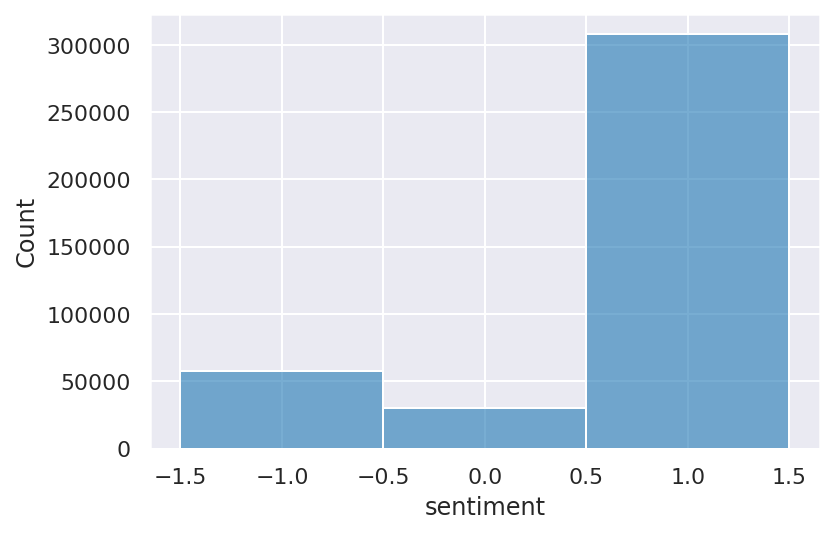

In [13]:
sns.histplot(df, x="sentiment", alpha=0.6, discrete=True)
plt.show()

In [ ]:
df.describe()

,Unnamed: 0,Score,sentiment
count,394970.000000,394970.000000,394970.000000
mean,261543.868960,4.178659,0.634076
std,167039.910688,1.312818,0.722777
min,0.000000,1.000000,-1.000000
25%,112825.250000,4.000000,1.000000
50%,248987.500000,5.000000,1.000000
75%,407288.750000,5.000000,1.000000
max,568453.000000,5.000000,1.000000


### Words distribution

Let's observe the most frequent words for positive and negative reviews through **word clouds**

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# Create stopword list

diff_stopwords = set(wordcloud.STOPWORDS) ^ set(
    nltk.corpus.stopwords.words("english")
)
print(len(diff_stopwords))

stopwords = set(wordcloud.STOPWORDS) | set(
    nltk.corpus.stopwords.words("english")
)
stopwords.update(["br", "href"])

print(len(stopwords))

81
227


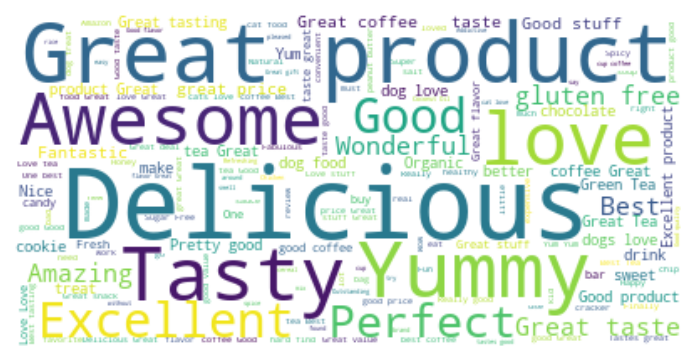

In [ ]:
positive_df = df[df.sentiment == 1]

pos_wordcloud = WordCloud(
    stopwords=stopwords,
    background_color="white",
).generate(" ".join(positive_df.Summary.dropna()))

plt.imshow(pos_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.savefig(IMG / "pos_wordcloud.png")
plt.show()

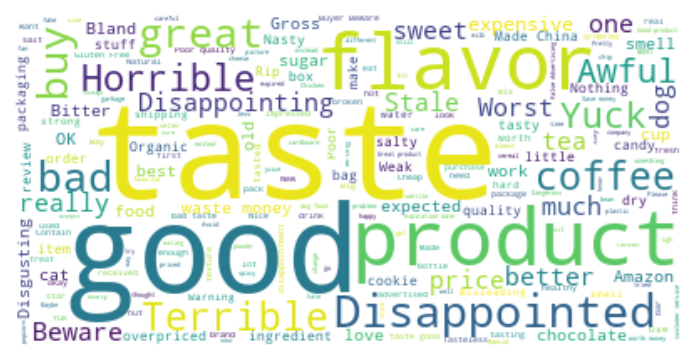

In [ ]:
negative_df = df[df.sentiment == -1]

neg_wordcloud = WordCloud(
    stopwords=stopwords,
    background_color="white",
).generate(" ".join(negative_df.Summary.dropna()))

plt.imshow(neg_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.savefig(IMG / "neg_wordcloud.png")
plt.show()

* Positive sentiment words, e.g., *love, best, delicious*

* Negative sentiment words, e.g., *disappointed, bad, yuck*

* The word ***good*** appears in the negative sentiment word cloud, despite being a positive word 

    * Probably because it was used in a negative context: ***not good*** 

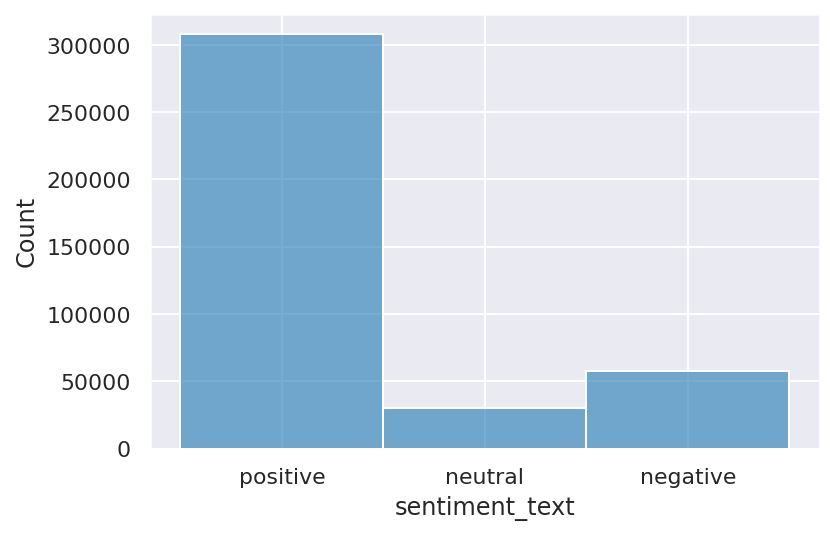

In [14]:
df["sentiment_text"] = (
    df.sentiment.replace({-1: "negative", 0: "neutral", 1: "positive"})
    .astype("category")  # To set the x-axis order in sns.histplot
    .cat.reorder_categories(["positive", "neutral", "negative"])
)

sns.histplot(
    df,
    x="sentiment_text",
    alpha=0.6,
    discrete=True,
)
plt.show()

## Create the train and test sets

It is **crucial** to keep the **test set** for the very last check when the model has been built, trying different approaches on the **validation set** (you will have to sample out of the training set later).

In [15]:
train_df, test_df = model_selection.train_test_split(
    df, test_size=0.2, random_state=1
)

In [16]:
train_df.shape

(315976, 6)

# BERT embeddings



In [ ]:
PRE_TRAINED_MODEL_NAME = "bert-base-cased"
tokenizer = BertTokenizerFast.from_pretrained(PRE_TRAINED_MODEL_NAME)

Check how the tokenizer works:

In [ ]:
sample_txt = df.iloc[0]["Text"]
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.
   Tokens: ['I', 'have', 'bought', 'several', 'of', 'the', 'Vita', '##lity', 'can', '##ned', 'dog', 'food', 'products', 'and', 'have', 'found', 'them', 'all', 'to', 'be', 'of', 'good', 'quality', '.', 'The', 'product', 'looks', 'more', 'like', 'a', 'stew', 'than', 'a', 'processed', 'meat', 'and', 'it', 'smells', 'better', '.', 'My', 'Labrador', 'is', 'fin', '##ick', '##y', 'and', 'she', 'appreciate', '##s', 'this', 'product', 'better', 'than', 'most', '.']
Token IDs: [146, 1138, 3306, 1317, 1104, 1103, 25118, 11796, 1169, 3540, 3676, 2094, 2982, 1105, 1138, 1276, 1172, 1155, 1106, 1129, 1104, 1363, 3068, 119, 1109, 3317, 2736, 1167, 1176, 170, 26036, 1190, 170, 14659, 6092, 1105, 1122, 16533, 1618, 119, 1422, 20255,

**Tokenizing with Bert tokenizer the whole dataframe**

In [ ]:
def fastTokenizerBert(row):
    encoding = tokenizer.encode_plus(row["Text"],
                                     max_length=150,
                                     padding="max_length",
                                     truncation=True,
                                     return_tensors="pt")
    row["input_ids"] = encoding["input_ids"]
    row["attention_mask"] = encoding["attention_mask"]
    return row

In [ ]:
new_train_df = test_df.apply(fastTokenizerBert, axis=1)
new_test_df = train_df.apply(fastTokenizerBert, axis=1)

In [ ]:
new_train_df.shape

(78994, 8)

In [ ]:
new_train_df.head(2)

,Unnamed: 0,Score,Summary,Text,sentiment,sentiment_text,input_ids,attention_mask
115375,133520,5,Hooray for Gooseberries!!!,Tried for a few years to obtain gooseberries b...,1,positive,"[[tensor(101), tensor(18491), tensor(1174), te...","[[tensor(1), tensor(1), tensor(1), tensor(1), ..."
290549,398096,4,"Really good, and with modifications....","If it's curry, chances are pretty great that I...",1,positive,"[[tensor(101), tensor(1409), tensor(1122), ten...","[[tensor(1), tensor(1), tensor(1), tensor(1), ..."


In [ ]:
new_train_df.iloc[0]["attention_mask"].size()

torch.Size([1, 150])

In [ ]:
# Instantiate model and move it to the GPU
model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
model = model.to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


**Create tensor dataset and move to GPU**

In [ ]:
'''We need to stack all the tensors in one single tensor
This can be done in two ways: 
1° Way
  a)we take the column of the dataframe, new_train_df["input_ids"].values, which gives us a numpy.ndarray
  b)we stack all of those values to get a single array, of lists of numpy arrays: tmp = np.vstack(new_train_df['input_ids'].values).astype(np.float)
  c)we create a tensor from that numpy array:  torch.from_numpy(tmp).to(device)
2° Way
  a)we create a list of tensors using all the values of one column of the dataframe
  b)we use concat from torch, so to keep the tensors in one dimension: torch.concat(list(new_train_df['input_ids'].values)).to(device)
'''
train_inputs_tensors = torch.concat(list(new_train_df["input_ids"].values))
train_masks_tensors = torch.concat(list(new_train_df["attention_mask"].values))

test_inputs_tensors = torch.concat(list(new_test_df["input_ids"].values))
test_masks_tensors = torch.concat(list(new_test_df["attention_mask"].values))

In [ ]:
print(train_inputs_tensors.shape)

torch.Size([78994, 150])


In [ ]:
# Convert to tensor dataset
# DataLoaders gives an iterator
train_data = TensorDataset(train_inputs_tensors, train_masks_tensors)
train_dataloader = DataLoader(train_data, batch_size=16)

test_data = TensorDataset(test_inputs_tensors, test_masks_tensors)
test_dataloader = DataLoader(test_data, batch_size=32)

In [ ]:
"""
# Dataloader is an iterator containing 2 matrices, the first is the input_id and the other is the attention mask
data_it = next(iter(train_dataloader)) 
print(data_it[0].shape) #batch of 16 samples
print(data_it[1].shape) #batch of 16 samples
torch.Size([16, 150])
torch.Size([16, 150])
"""

torch.Size([16, 150])
torch.Size([16, 150])


**Bert embeddings for train set**

In [ ]:
bert_features_arr = []
start_time = time.time()
for batch in train_dataloader:
  # Send data to GPU
  input_ids_gpu = batch[0].to(device)
  attention_mask_gpu = batch[1].to(device)
  # Model returns object with keys
  model_output = model(
    input_ids = input_ids_gpu,
    attention_mask = attention_mask_gpu
  )
  bert_ft_batch = model_output.last_hidden_state[:, 0, :].cpu().detach().numpy()
  bert_features_arr.append(bert_ft_batch)

runtime = time.time()-start_time
print("Model trained in %s seconds" % (runtime))

Model trained in 1914.7494320869446 seconds


In [ ]:
torch.cuda.empty_cache()
#del train_inputs_tensors, train_masks_tensors, train_data, train_df, test_df

In [ ]:
del test_inputs_tensors, test_masks_tensors

**Bert embeddings for test set**

In [ ]:
bert_features_arr_test = []
start_time = time.time()
for batch in test_dataloader:
  # Send data to GPU
  input_ids_gpu = batch[0].to(device)
  attention_mask_gpu = batch[1].to(device)
  # Model returns object with keys
  model_output = model(
    input_ids = input_ids_gpu,
    attention_mask = attention_mask_gpu
  )
  bert_ft_batch = model_output.last_hidden_state[:, 0, :].cpu().detach().numpy()
  bert_features_arr_test.append(bert_ft_batch)

runtime = time.time()-start_time
print("Model trained in %s seconds" % (runtime))

RuntimeError: ignored

In [ ]:
"""
Model outputs have the following shape:
model_output["last_hidden_state"].shape 
>> [16, 150, 768]
#16: number of samples in the batch
#150: number of tokens 
#768: number of hidden units in the feedforward-network
"""

torch.Size([16, 150, 768])

In [ ]:
len(bert_features_arr)

4938

In [ ]:
#Save the learned embeddings
np.savez_compressed("/content/drive/MyDrive/saclay/hands_on_nlp/project/archive/bert_features_arr", bert_features_arr=bert_features_arr)
np.savez_compressed("/content/drive/MyDrive/saclay/hands_on_nlp/project/archive/bert_features_arr_test", bert_features_arr_test=bert_features_arr_test)

In [ ]:
# Convert array of features to numpy array
#bert_features = np.concatenate(bert_features_arr, axis=0)
bert_features_test = np.concatenate(bert_features_arr_test, axis=0)

In [ ]:
print(bert_features.shape)
print(bert_features_test.shape)

(78994, 768)

For the meantime, we are going to use only the 20% of the original dataset, as this is the portion of data that could be passed to BERT.

In [17]:
loaded = np.load("/content/drive/MyDrive/saclay/hands_on_nlp/project/archive/bert_features_arr.npz", allow_pickle=True)
bert_features_arr = loaded["bert_features_arr"]
bert_features = np.concatenate(bert_features_arr, axis=0)
print(bert_features.shape)

(78994, 768)


In [28]:
# Split in train and test sets
target = test_df["sentiment"].to_numpy() 
X_train, X_test, y_train, y_test = model_selection.train_test_split(bert_features, target, stratify=target, test_size=0.4, random_state=1)

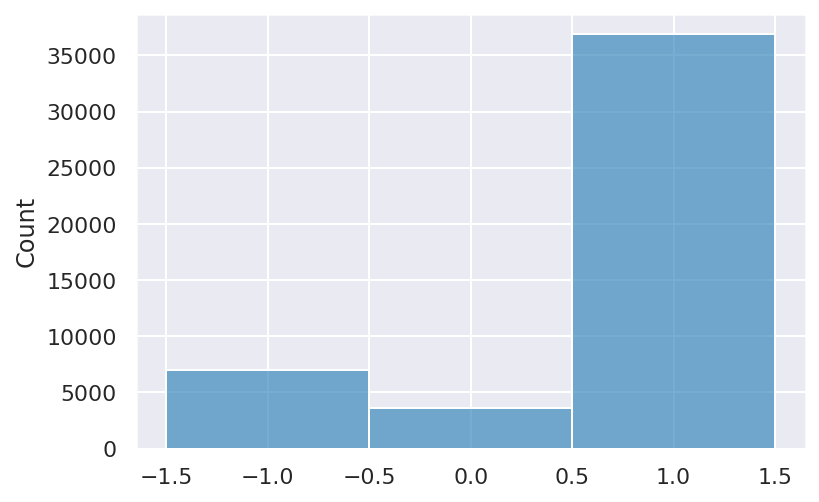

In [29]:
sns.histplot(y_train, alpha=0.6, discrete=True)
plt.show()

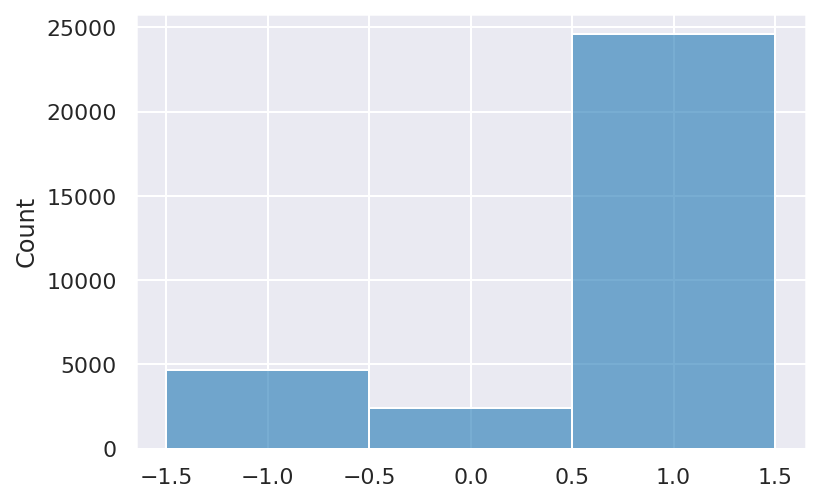

In [30]:
sns.histplot(y_test, alpha=0.6, discrete=True)
plt.show()

In [31]:
# Make a new split over the train data, to get a validation set too
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X_train, y_train, stratify=y_train, test_size=0.2, random_state=1)
print(X_train.shape)
print(X_valid.shape)

(37916, 768)
(9480, 768)


## Random Forest

In [ ]:
clf = ensemble.RandomForestClassifier(max_depth = 6, random_state=1, class_weight='balanced', n_estimators=150)
start_time = time.time()
clf.fit(X_train, y_train)
runtime = time.time()-start_time
print("Random forest model trained in %s seconds" % (runtime))

Random forest model trained in 142.0983180999756 seconds


In [ ]:
# Predict
y_pred = clf.predict(X_test)

# Performance 
metrics.confusion_matrix(y_pred, y_test)
print(metrics.classification_report(y_pred, y_test))

              precision    recall  f1-score   support

          -1       0.63      0.39      0.48      3700
           0       0.46      0.15      0.23      3561
           1       0.65      0.94      0.77      8538

    accuracy                           0.63     15799
   macro avg       0.58      0.49      0.49     15799
weighted avg       0.60      0.63      0.58     15799



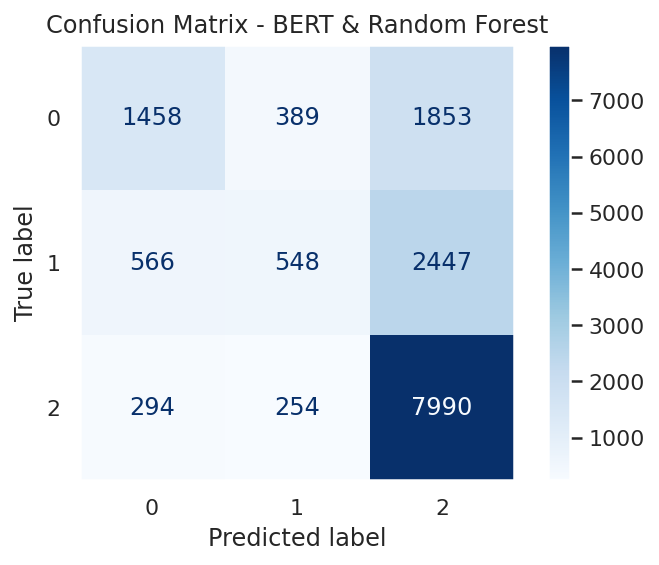

In [ ]:
disp = metrics.ConfusionMatrixDisplay(
    metrics.confusion_matrix(y_pred, y_test)
)
disp.plot(cmap=plt.cm.Blues)
plt.grid(False)
plt.title("Confusion Matrix - BERT & Random Forest")
plt.show()

## Linear Model

In [32]:
clf = linear_model.SGDClassifier(class_weight="balanced", loss="log", random_state=1)
start_time = time.time()
clf.fit(X_train, y_train)
runtime = time.time()-start_time
print("Linear model trained in %s seconds" % (runtime))

Linear model trained in 21.380367755889893 seconds


In [33]:
# Predict
y_pred = clf.predict(X_valid)

# Performance 
metrics.confusion_matrix(y_pred, y_valid)
print(metrics.classification_report(y_pred, y_valid))

              precision    recall  f1-score   support

          -1       0.35      0.76      0.48       649
           0       0.56      0.22      0.32      1829
           1       0.87      0.92      0.89      7002

    accuracy                           0.77      9480
   macro avg       0.59      0.63      0.56      9480
weighted avg       0.78      0.77      0.75      9480



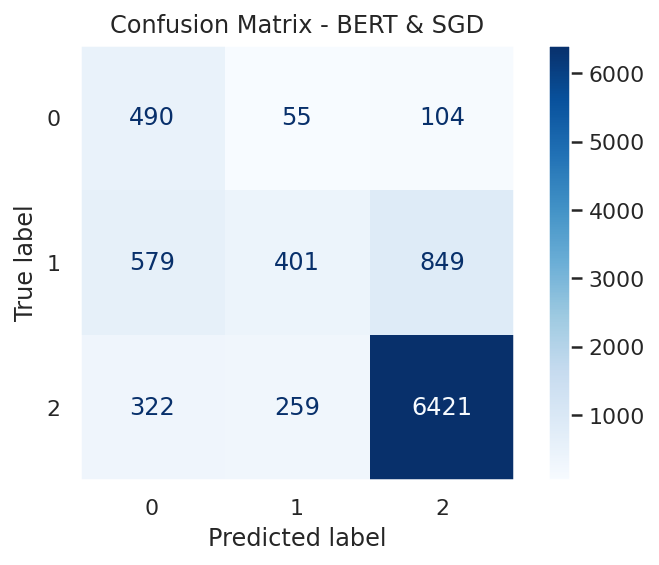

In [34]:
disp = metrics.ConfusionMatrixDisplay(
    metrics.confusion_matrix(y_pred, y_valid)
)
disp.plot(cmap=plt.cm.Blues)
plt.grid(False)
plt.title("Confusion Matrix - BERT & SGD")
plt.show()

In [35]:
# Test prediction
y_pred = clf.predict(X_test)

# Performance 
metrics.confusion_matrix(y_pred, y_test)
print(metrics.classification_report(y_pred, y_test))

              precision    recall  f1-score   support

          -1       0.34      0.76      0.47      2101
           0       0.58      0.23      0.32      6129
           1       0.87      0.92      0.89     23368

    accuracy                           0.77     31598
   macro avg       0.60      0.63      0.56     31598
weighted avg       0.78      0.77      0.76     31598



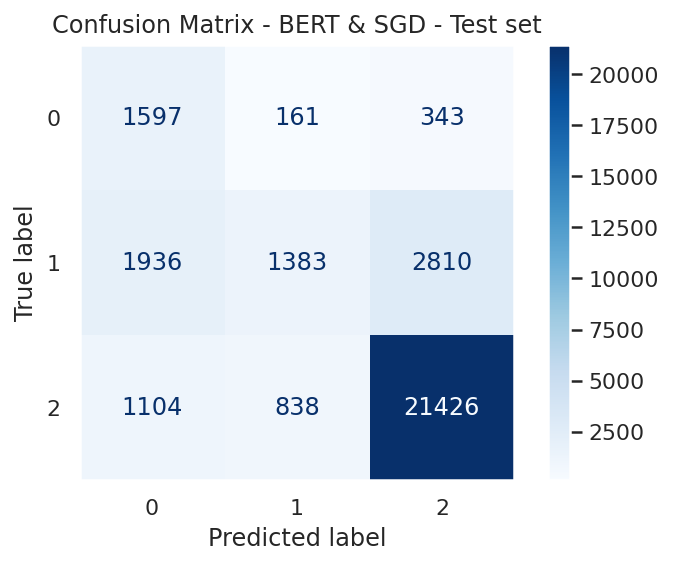

In [36]:
disp = metrics.ConfusionMatrixDisplay(
    metrics.confusion_matrix(y_pred, y_test)
)
disp.plot(cmap=plt.cm.Blues)
plt.grid(False)
plt.title("Confusion Matrix - BERT & SGD - Test set")
plt.show()

Light GBM

In [37]:
clf = LGBMClassifier(random_state=1, objective='softmax', num_class=3, boosting='dart')
start_time = time.time()
clf.fit(X_train, y_train)
runtime = time.time()-start_time
print("LGBM model trained in %s seconds" % (runtime))

LGBM model trained in 115.18096160888672 seconds


In [38]:
# Predict
y_pred = clf.predict(X_valid)

# Performance 
metrics.confusion_matrix(y_pred, y_valid)
print(metrics.classification_report(y_pred, y_valid))

              precision    recall  f1-score   support

          -1       0.32      0.68      0.44       654
           0       0.01      0.42      0.01        12
           1       0.98      0.82      0.90      8814

    accuracy                           0.81      9480
   macro avg       0.44      0.64      0.45      9480
weighted avg       0.94      0.81      0.86      9480



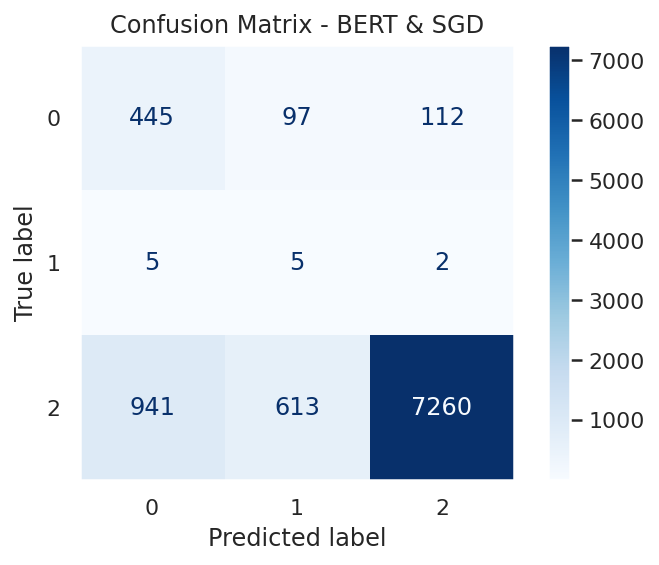

In [39]:
disp = metrics.ConfusionMatrixDisplay(
    metrics.confusion_matrix(y_pred, y_valid)
)
disp.plot(cmap=plt.cm.Blues)
plt.grid(False)
plt.title("Confusion Matrix - BERT & SGD")
plt.show()

In [40]:
# Predict
y_pred = clf.predict(X_test)
# Performance 
metrics.confusion_matrix(y_pred, y_test)
print(metrics.classification_report(y_pred, y_test))

              precision    recall  f1-score   support

          -1       0.33      0.68      0.44      2237
           0       0.01      0.46      0.01        37
           1       0.98      0.82      0.90     29324

    accuracy                           0.81     31598
   macro avg       0.44      0.66      0.45     31598
weighted avg       0.94      0.81      0.86     31598



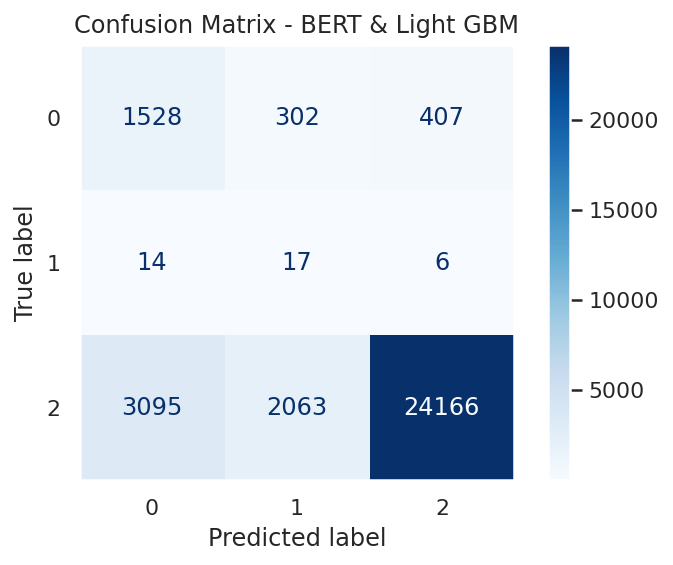

In [41]:
disp = metrics.ConfusionMatrixDisplay(
    metrics.confusion_matrix(y_pred, y_test)
)
disp.plot(cmap=plt.cm.Blues)
plt.grid(False)
plt.title("Confusion Matrix - BERT & Light GBM")
plt.show()

In [ ]:
from sklearn.decomposition import PCA

Do some PCA

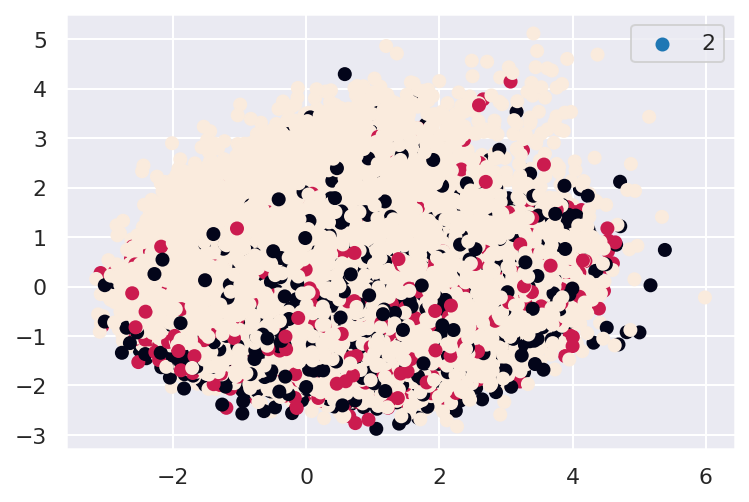

In [ ]:
N_COMP = 64
pca = PCA(n_components=N_COMP)
X_train_pca = pca.fit_transform(X_train)
labels_for_pca = list(y_train+1)
plot = plt.scatter(X_train_pca[:,0], X_train_pca[:,1], c=y_train+1)
plt.legend(labels=labels_for_pca)
plt.show()

---